In [102]:
import obspy
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
import obspy.signal.trigger
from scatseisnet import ScatteringNetwork
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import dates as mdates
import sklearn.decomposition
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, DBSCAN
import umap
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd
import datetime
from scipy import signal
from matplotlib import cm
from scipy.ndimage import gaussian_filter1d

In [195]:
def load_lunar(base_dir: Path):
    print("> Loading lunar")
    cat_file = (
        base_dir / "data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
    )
    cat = pd.read_csv(cat_file)
    # for convenient access
    cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
    cat["arrival_time_rel"] = cat["time_rel(sec)"]

    train_dir = base_dir / "data/lunar/training/data/"
    test_dir = base_dir / "data/lunar/test/data/"

    # get from df so we can match with arrival times
    train_filenames = [train_dir / f"S12_GradeA/{x}.mseed" for x in cat.filename]
    test_filenames = list(test_dir.rglob("*.mseed"))

    print("training data: ", len(list(train_dir.rglob("*.mseed"))))
    print("test data: ", len(test_filenames))

    for i, f in enumerate(train_filenames):
        if "evid00029" in str(f):
            train_filenames[i] = Path(
                "../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed"
            )
    train_streams = []
    for f in train_filenames:
        try:
            train_streams.append(obspy.read(f))
        except Exception as e:
            print(f"Error reading file {f}: {e}")

    test_streams = []
    for f in test_filenames:
        try:
            test_streams.append(obspy.read(f))
        except Exception as e:
            print(f"Error reading file {f}: {e}")
    arr_times = cat["arrival_time_rel"].to_numpy()
    return train_streams, arr_times, test_streams, train_filenames, test_filenames


def load_martian(base_dir: Path):
    print("> Loading martian")
    base_dir = Path("../data/space_apps_2024_seismic_detection")
    cat_file = (
        base_dir / "data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"
    )
    cat = pd.read_csv(cat_file)
    # for convenient access
    cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
    cat["arrival_time_rel"] = cat["time_rel(sec)"]
    train_dir = base_dir / "data/mars/training/data/"
    test_dir = base_dir / "data/mars/test/data/"

    # get from df so we can match with arrival times
    train_filenames = [train_dir / f"{x[:-4]}.mseed" for x in cat.filename]
    test_filenames = list(test_dir.rglob("*.mseed"))

    print("training data: ", len(list(train_dir.rglob("*.mseed"))))
    print("test data: ", len(test_filenames))

    train_streams = []
    for f in train_filenames:
        try:
            train_streams.append(obspy.read(f))
        except Exception as e:
            print(f"Error reading file {f}: {e}")

    test_streams = []
    for f in test_filenames:
        try:
            test_streams.append(obspy.read(f))
        except Exception as e:
            print(f"Error reading file {f}: {e}")
    arr_times = cat["arrival_time_rel"].to_numpy()
    return train_streams, arr_times, test_streams, train_filenames, test_filenames


base_dir = Path("../data/space_apps_2024_seismic_detection")
X_train, y_train, X_test, train_filenames, test_filenames = load_lunar(base_dir)
# X_train, y_train, X_test, train_filenames, test_filenames = load_martian(base_dir)

> Loading lunar
training data:  76
test data:  96


# Visualise


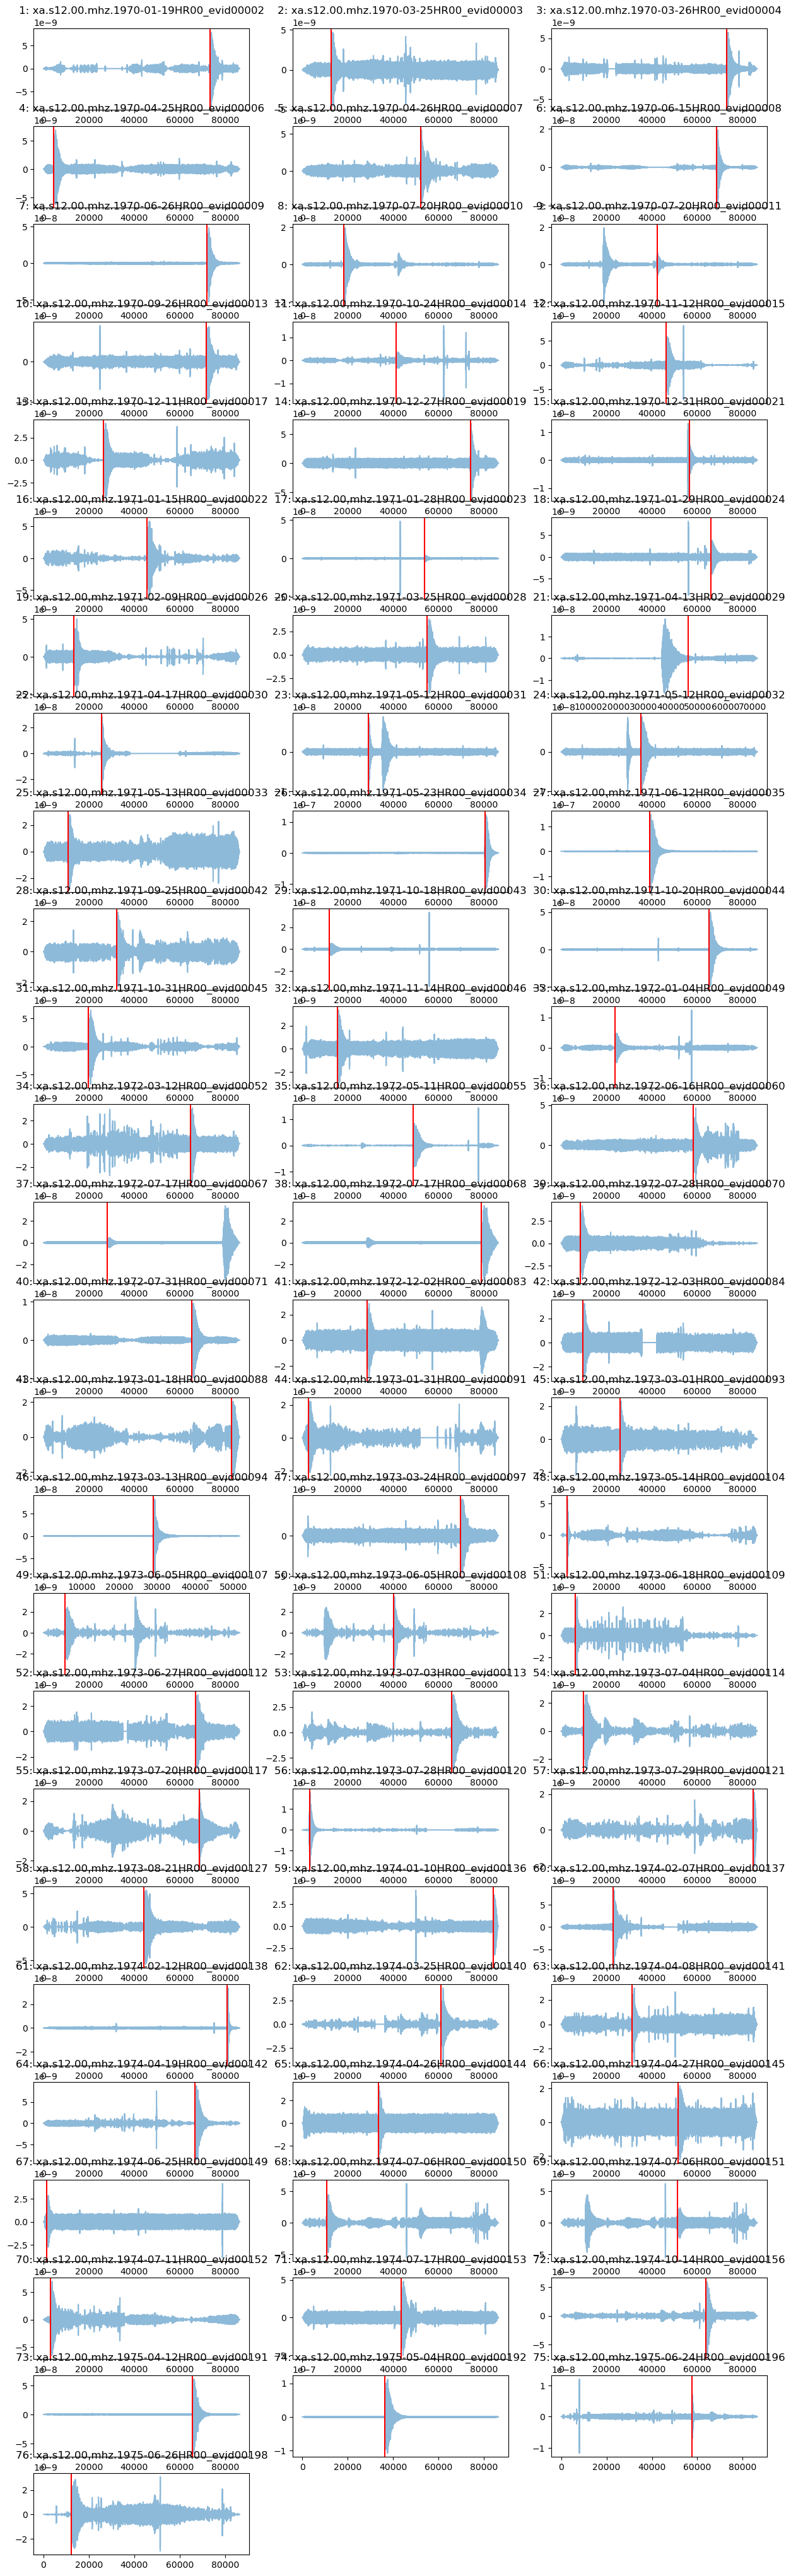

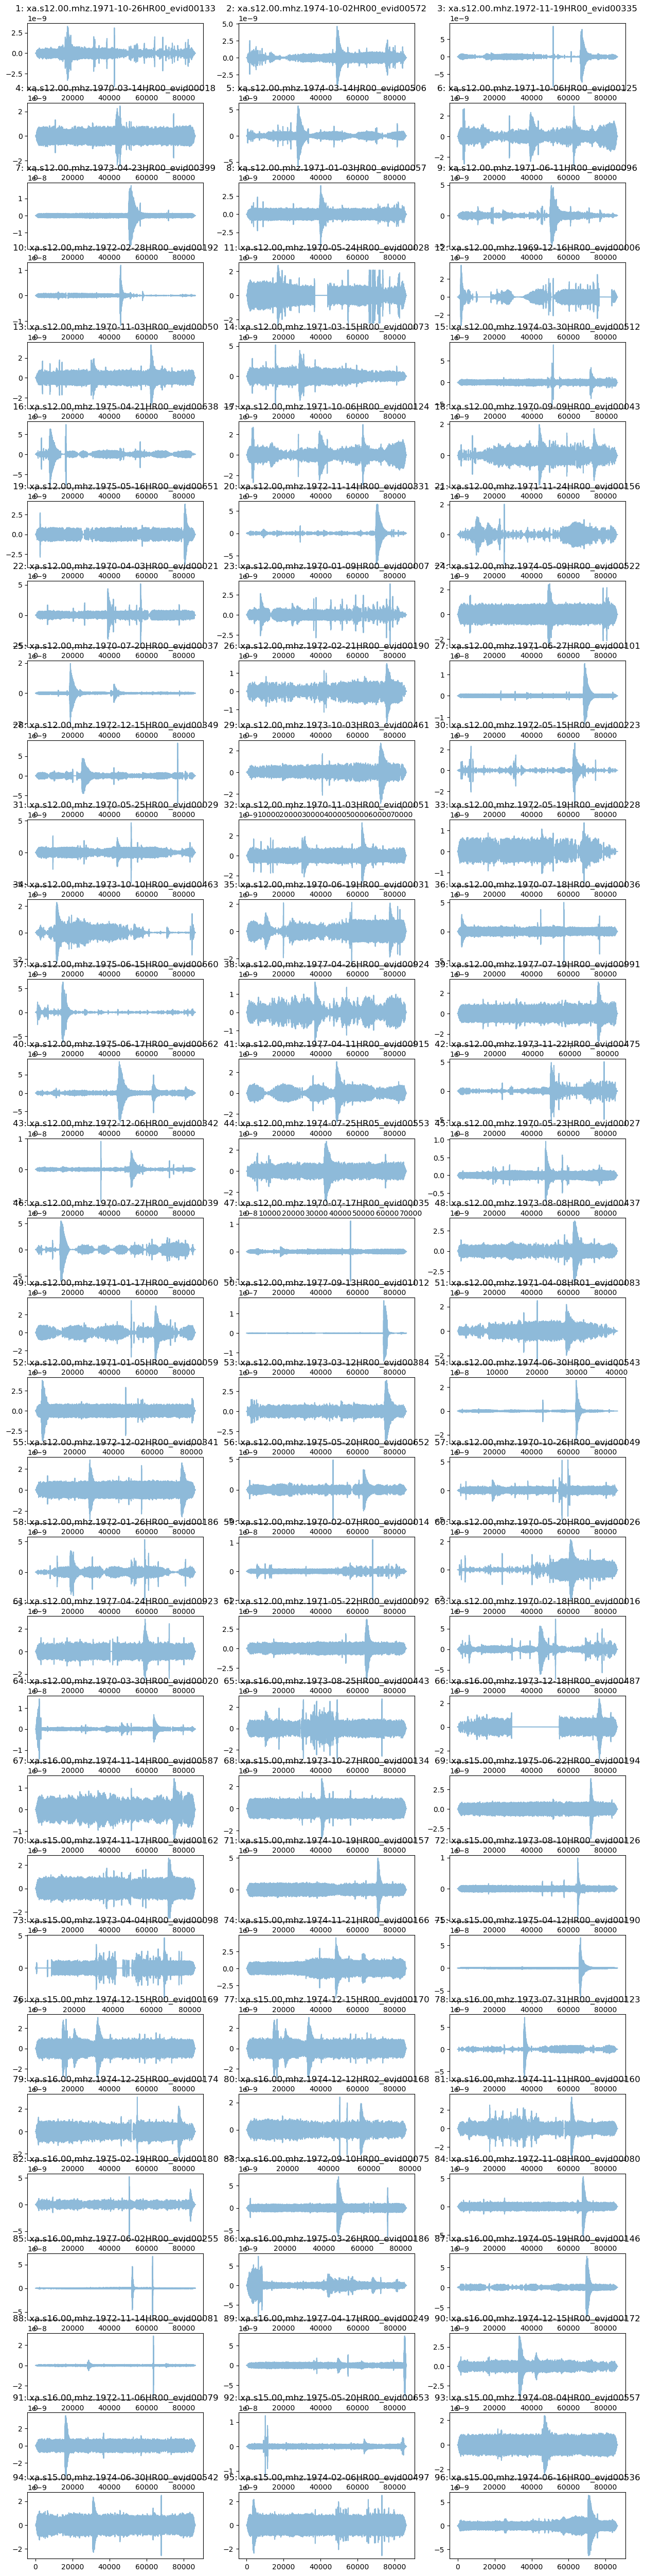

In [196]:
nrows = (len(X_train) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(X_train):
    x, y = stream[0].times(), stream[0].data

    axs[i].plot(x, y, alpha=0.5)
    axs[i].axvline(x=y_train[i], c="red")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.show()

nrows = (len(X_test) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

for i, stream in enumerate(X_test):
    x, y = stream[0].times(), stream[0].data
    axs[i].plot(x, y, alpha=0.5)
    axs[i].set_title(f"{i+1}: {test_filenames[i].stem}")
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.show()


# STA/LTA


In [205]:
stream = X_train[1]
out = obspy.signal.trigger.classic_sta_lta(
    stream[0].data,
    nsta=600 * stream[0].stats.sampling_rate,
    nlta=10000 * stream[0].stats.sampling_rate,
)


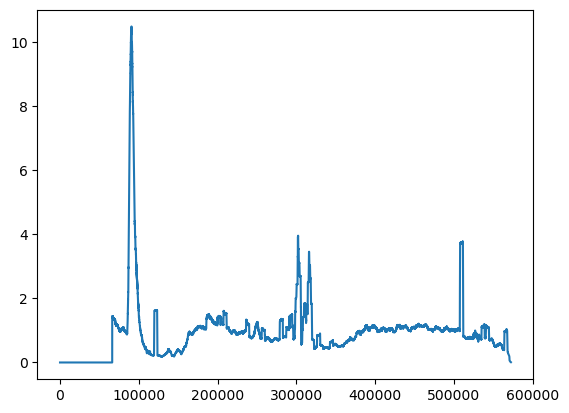

In [206]:
plt.plot(out)

In [207]:
trg_on = 3  # above this is an event
trg_off = 1.5
t = obspy.signal.trigger.trigger_onset(out, trg_on, trg_off)
t

array([[ 86954, 100025],
       [301671, 305858],
       [315827, 319754],
       [507799, 511792]])

In [208]:
stream[0].times()[t[0, 0]]

13125.132075471698

In [209]:
# v = 0 + datetime.timedelta(seconds=stream[0].times()[t[0, 0]])
v = seconds = stream[0].times()[t[0, 0]]

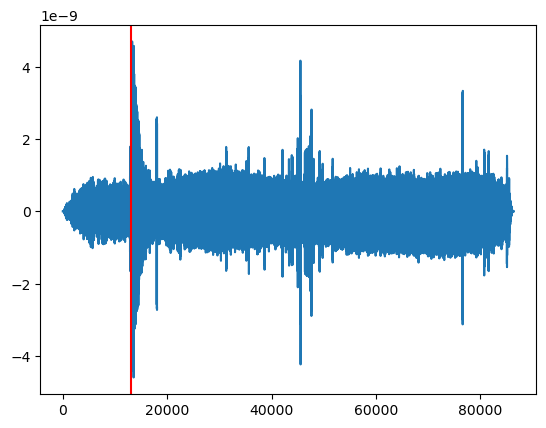

In [210]:
plt.plot(stream[0].times(), stream[0].data)
plt.axvline(v, c="r")

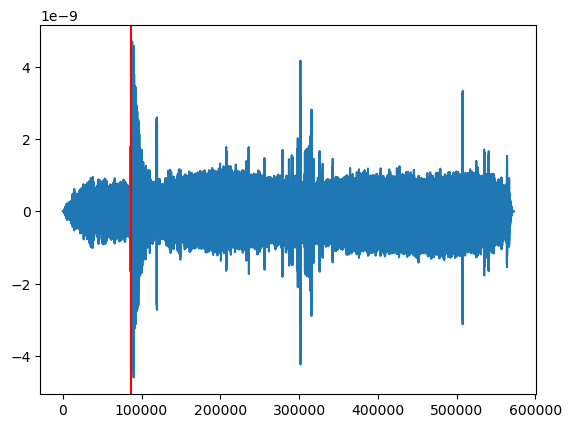

In [211]:
plt.plot(stream[0].data)
plt.axvline(t[0, 0], c="r")

In [212]:
def make_stalta_prediction(stream, sta_len=120, lta_len=600, trg_on=3):
    out = obspy.signal.trigger.classic_sta_lta(
        stream[0].data,
        nsta=sta_len * stream[0].stats.sampling_rate,
        nlta=lta_len * stream[0].stats.sampling_rate,
    )
    t = obspy.signal.trigger.trigger_onset(out, trg_on, 1)
    assert len(t) > 0
    arr_time = stream[0].times()[t[0, 0]]
    return arr_time, out


yhat_train = []
for stream in X_train:
    try:
        # result, _ = make_stalta_prediction(stream) # mars
        result, _ = make_stalta_prediction(stream, 600, 10000)  # lunar
        yhat_train.append(result)
    except Exception:
        yhat_train.append(float("nan"))
yhat_train = np.array(yhat_train)

yhat_test = []
for stream in X_test:
    try:
        # result, _ = make_stalta_prediction(stream) # mars
        result, _ = make_stalta_prediction(stream, 600, 10000)  # lunar
        yhat_test.append(result)
    except Exception:
        yhat_test.append(float("nan"))
yhat_test = np.array(yhat_test)

In [214]:
err = np.abs(yhat_train - y_train)
print("Absolute errors on train=>", err)
print("MAE on train=>", np.nanmean(err))

Absolute errors on train=> [5.54435472e+04 4.05132075e+02 2.20000000e+02            nan
 2.62716981e+02 5.53107925e+04 1.32301887e+02 6.02098113e+03
 2.99009811e+04 4.69842264e+04 1.91295849e+04 3.59538113e+04
 2.71396226e+02 5.06114717e+04 1.61796981e+04 9.10339623e+02
 1.08699623e+04 1.00604528e+04 3.75396226e+02 3.72981132e+02
 2.66304151e+04 1.16585660e+04 8.65660377e+01 5.91343396e+03
 2.91018868e+02 3.97394717e+04 1.92776604e+04 1.89806038e+04
 2.90037736e+02 4.93495849e+04 2.25811321e+02 2.50188679e+02
 3.07849057e+02 5.29990943e+04 2.94052075e+04 3.29584906e+02
 3.08679245e+02 5.04513208e+04 1.41984906e+03 2.29049057e+04
 4.63849057e+02 5.19849057e+02 7.00313208e+04 2.63228679e+04
 2.97433962e+02 5.51698113e+01 1.00612075e+04 7.12768302e+04
 5.19849057e+02 3.02001509e+04 5.94387925e+04 2.13411321e+04
 3.69674717e+04 2.31698113e+02 5.54081509e+04 2.83581887e+04
 6.51988679e+04 2.94083774e+04 3.40778113e+04 1.17811321e+02
 4.90345660e+04 4.82815094e+04 1.48830189e+02 4.42084528e+

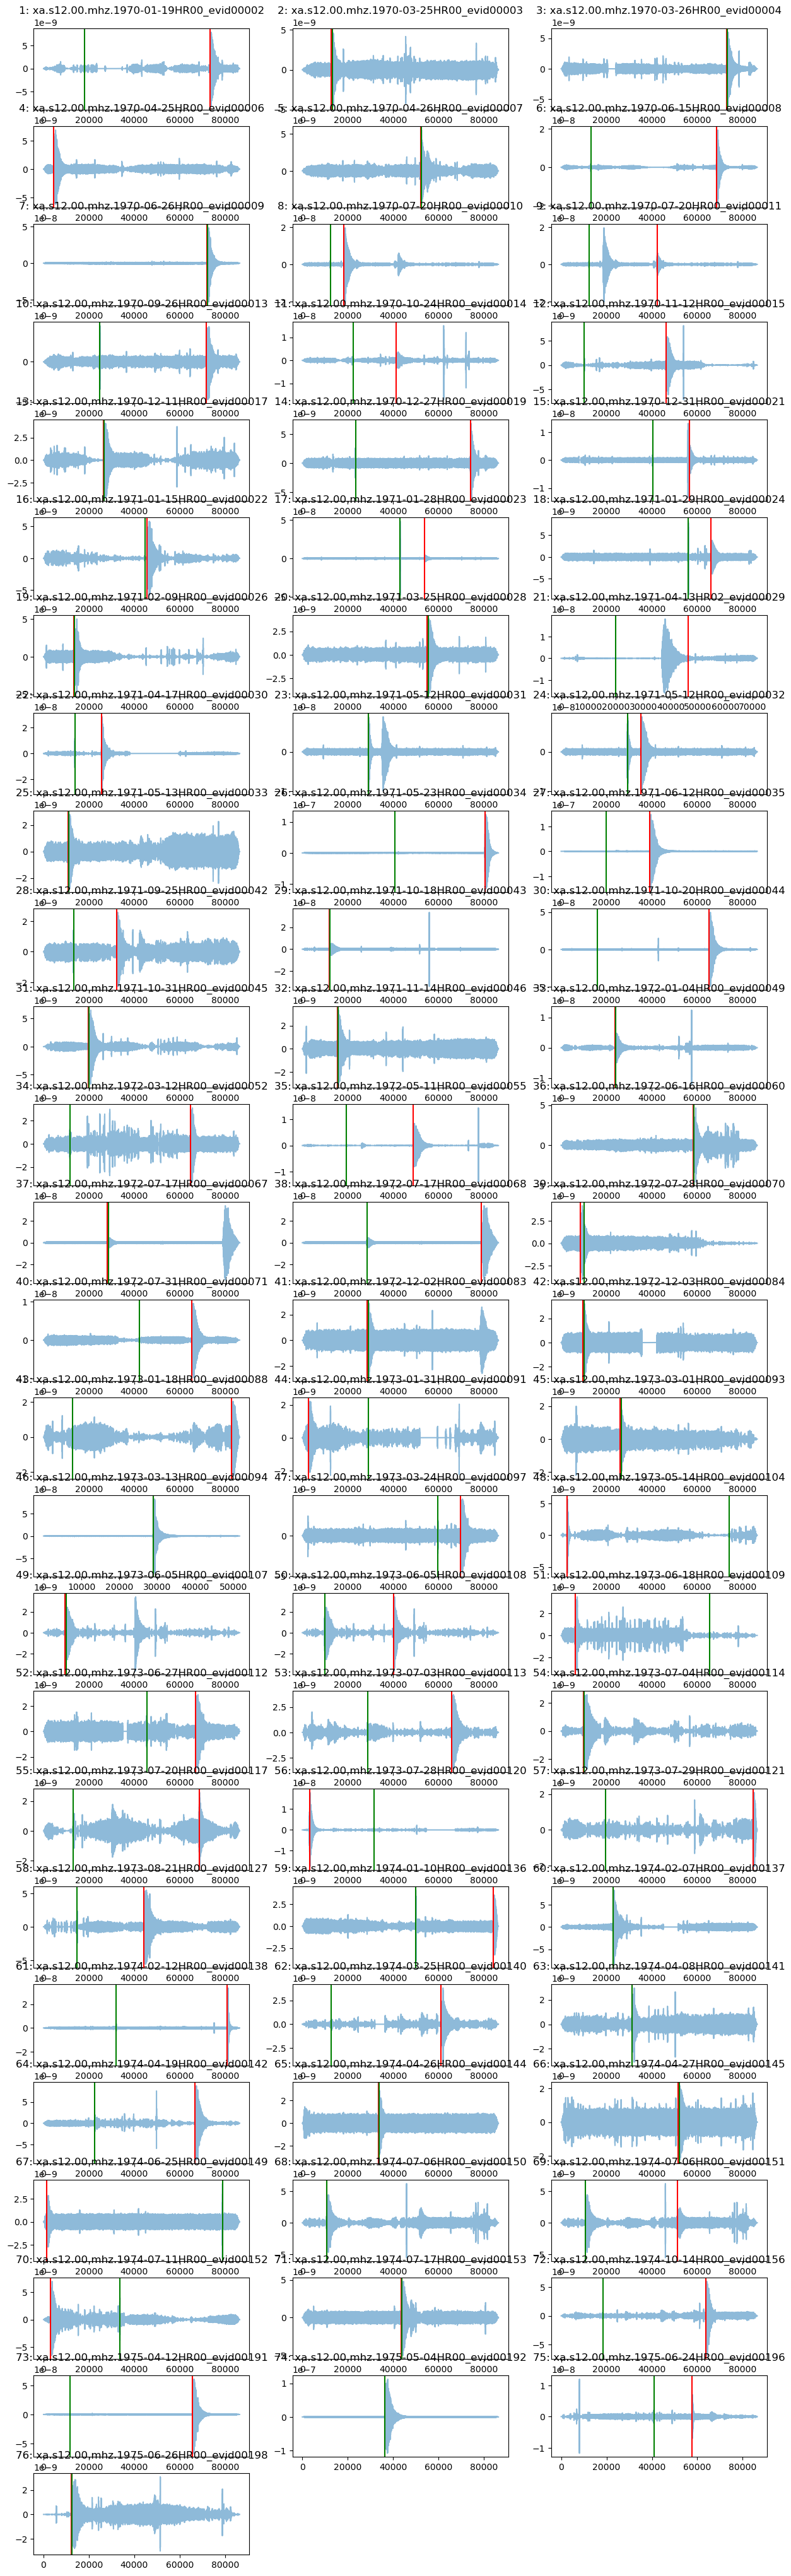

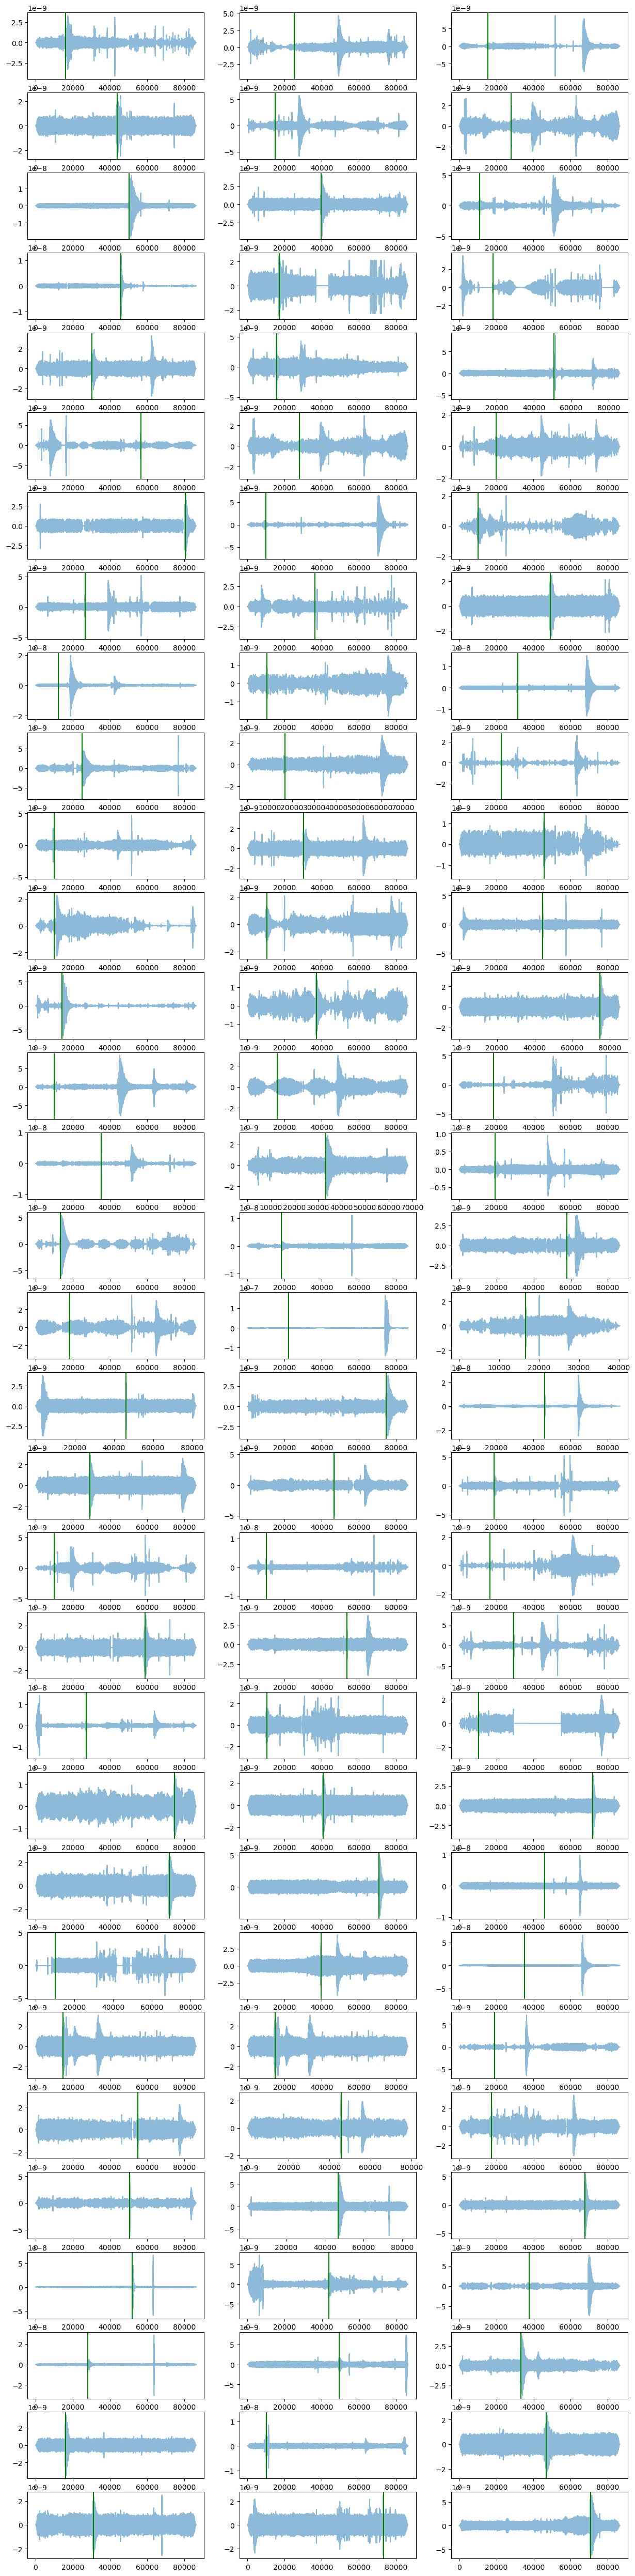

In [215]:
def show_predictions(
    yhat_train, yhat_test, X_train=X_train, y_train=y_train, X_test=X_test
):
    nrows = (len(X_train) + 2) // 3
    fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
    axs = axs.flatten()

    for i, stream in enumerate(X_train):
        x, y = stream[0].times(), stream[0].data

        axs[i].plot(x, y, alpha=0.5)
        axs[i].axvline(x=y_train[i], c="red")
        axs[i].axvline(x=yhat_train[i], c="green")
        axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.show()

    nrows = (len(X_test) + 2) // 3
    fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
    axs = axs.flatten()

    for i, stream in enumerate(X_test):
        x, y = stream[0].times(), stream[0].data
        axs[i].plot(x, y, alpha=0.5)
        axs[i].axvline(x=yhat_test[i], c="green")
    plt.show()


show_predictions(yhat_train, yhat_test)

# Spectogram


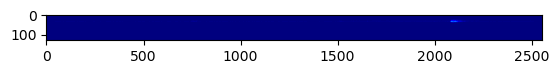

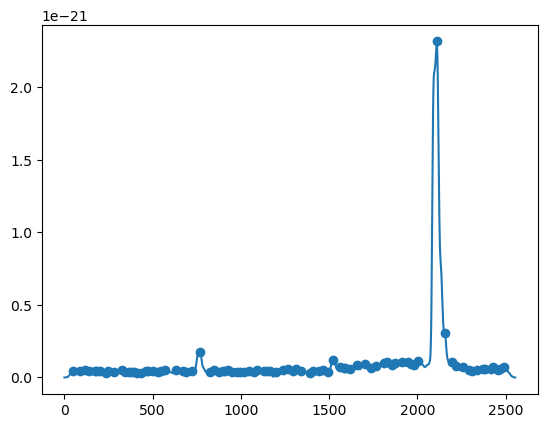

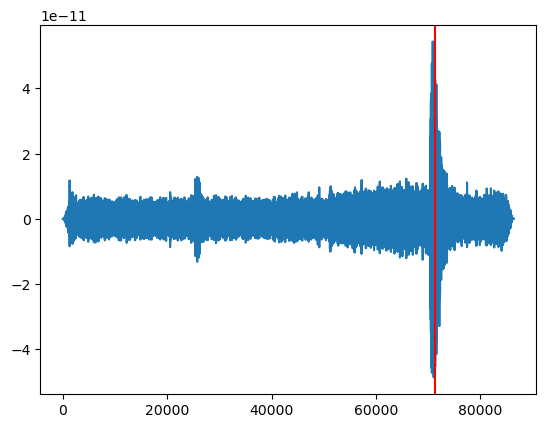

In [218]:
# stream = X_train[0]
stream = X_test[-1].copy()
stream = stream.filter("lowpass", freq=1.0)
# stream = stream.filter("highpass", freq=5.0)
stream = stream.filter("highpass", freq=2.0)
f, t, sxx = signal.spectrogram(stream[0].data, stream[0].stats.sampling_rate)
# maximum power along each timestep
maxpwr = np.max(sxx, axis=0)
smoothed_maxpwr = gaussian_filter1d(maxpwr, sigma=5)
# smoothed_maxpwr = maxpwr

peaks = signal.find_peaks(smoothed_maxpwr)[0]


plt.imshow(sxx, cmap=cm.jet)
plt.show()

x = np.arange(len(smoothed_maxpwr))
plt.plot(x, smoothed_maxpwr)
plt.scatter(x[peaks], smoothed_maxpwr[peaks])
plt.show()

plt.plot(stream[0].times(), stream[0].data)
max_val_peak = peaks[np.argmax(smoothed_maxpwr[peaks])]
time = t[max_val_peak]
plt.axvline(time, c="r")

In [230]:
! du -h baselines.ipynb

5.8M	baselines.ipynb


In [219]:
def make_spectogram_prediction(stream):
    stream2 = stream.copy()
    stream2 = stream2.filter("lowpass", freq=1.0)
    stream2 = stream2.filter("highpass", freq=2.0)
    f, t, sxx = signal.spectrogram(stream2[0].data, stream[0].stats.sampling_rate)
    maxpwr = np.max(sxx, axis=0)
    # smooth it
    smoothed_maxpwr = gaussian_filter1d(maxpwr, sigma=5)  # Adjust sigma as needed
    # peaks = signal.find_peaks(smoothed_maxpwr, width=10, threshold=1e3)[0]
    peaks = signal.find_peaks(smoothed_maxpwr)[0]
    assert len(peaks) > 0
    max_val_peak = peaks[np.argmax(smoothed_maxpwr[peaks])]
    return t[max_val_peak], stream2, sxx, t


yhat_train = []

for stream in X_train:
    try:
        result, s, *_ = make_spectogram_prediction(stream)
        yhat_train.append(result)
    except Exception:
        yhat_train.append(float("nan"))
yhat_train = np.array(yhat_train)

yhat_test = []
for stream in X_test:
    try:
        result, *_ = make_spectogram_prediction(stream)
        yhat_test.append(result)
    except Exception:
        yhat_test.append(float("nan"))
yhat_test = np.array(yhat_test)

In [220]:
err = np.abs(yhat_train - y_train)
print("Absolute errors on train=>", err)
print("MAE on train=>", np.mean(err))

Absolute errors on train=> [  599.9245283    722.41509434   538.94339623   887.69811321
   388.30188679   594.41509434   856.52830189   559.8490566
 23320.1509434    623.16981132   586.79245283   749.43396226
   818.86792453   398.03773585   362.33962264   876.0754717
 10845.05660377   669.05660377   697.20754717   761.81132075
  9051.54716981   478.79245283  6590.26415094   590.26415094
   715.16981132   394.56603774   518.56603774   562.49056604
 44003.24528302   603.77358491   945.66037736   659.69811321
   798.71698113   678.03773585   754.33962264   726.26415094
 51783.09433962  1023.09433962   669.81132075   874.26415094
   619.9245283    784.1509434    571.8490566    861.88679245
   393.58490566   439.9245283    465.43396226   219.47169811
 31112.90566038   392.90566038   560.1509434    681.96226415
   860.           878.94339623   305.35849057   348.0754717
   428.60377358   768.37735849   622.86792453   489.13207547
   335.54716981   983.09433962   500.52830189   531.47169811


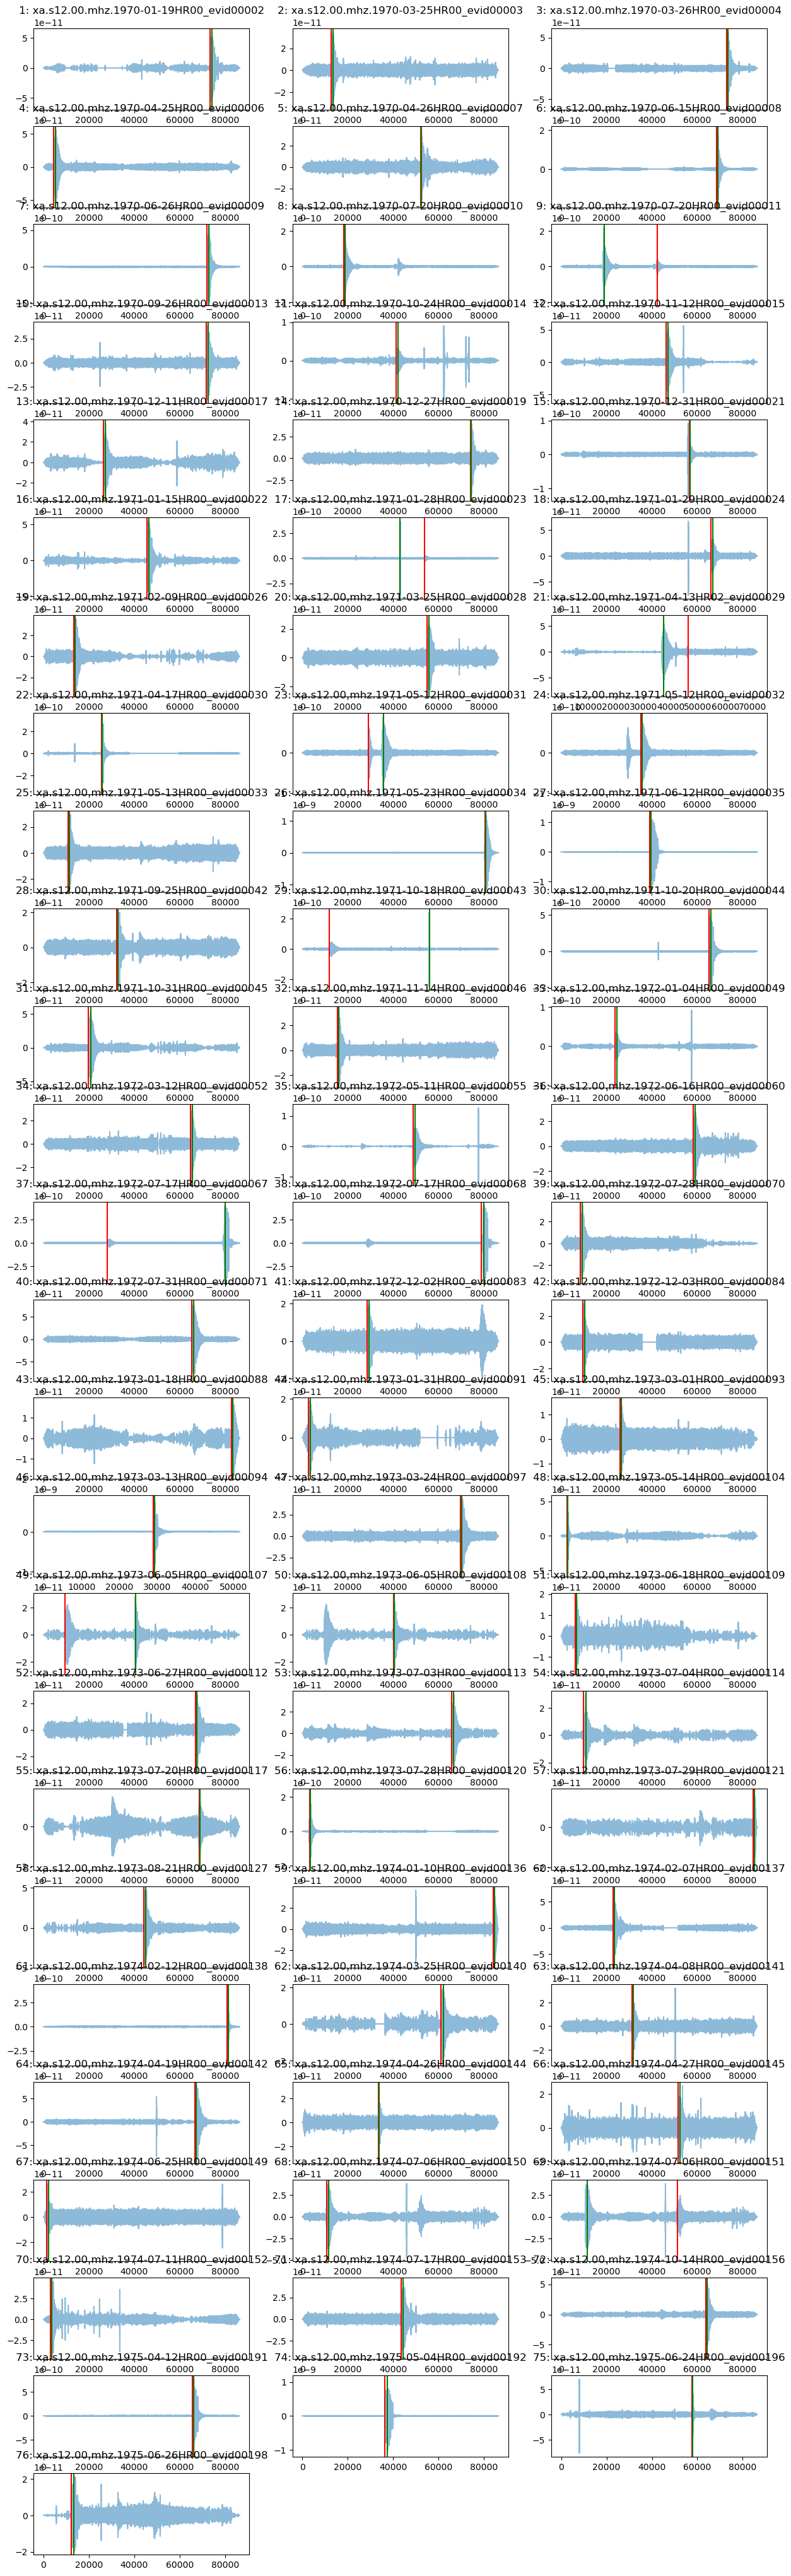

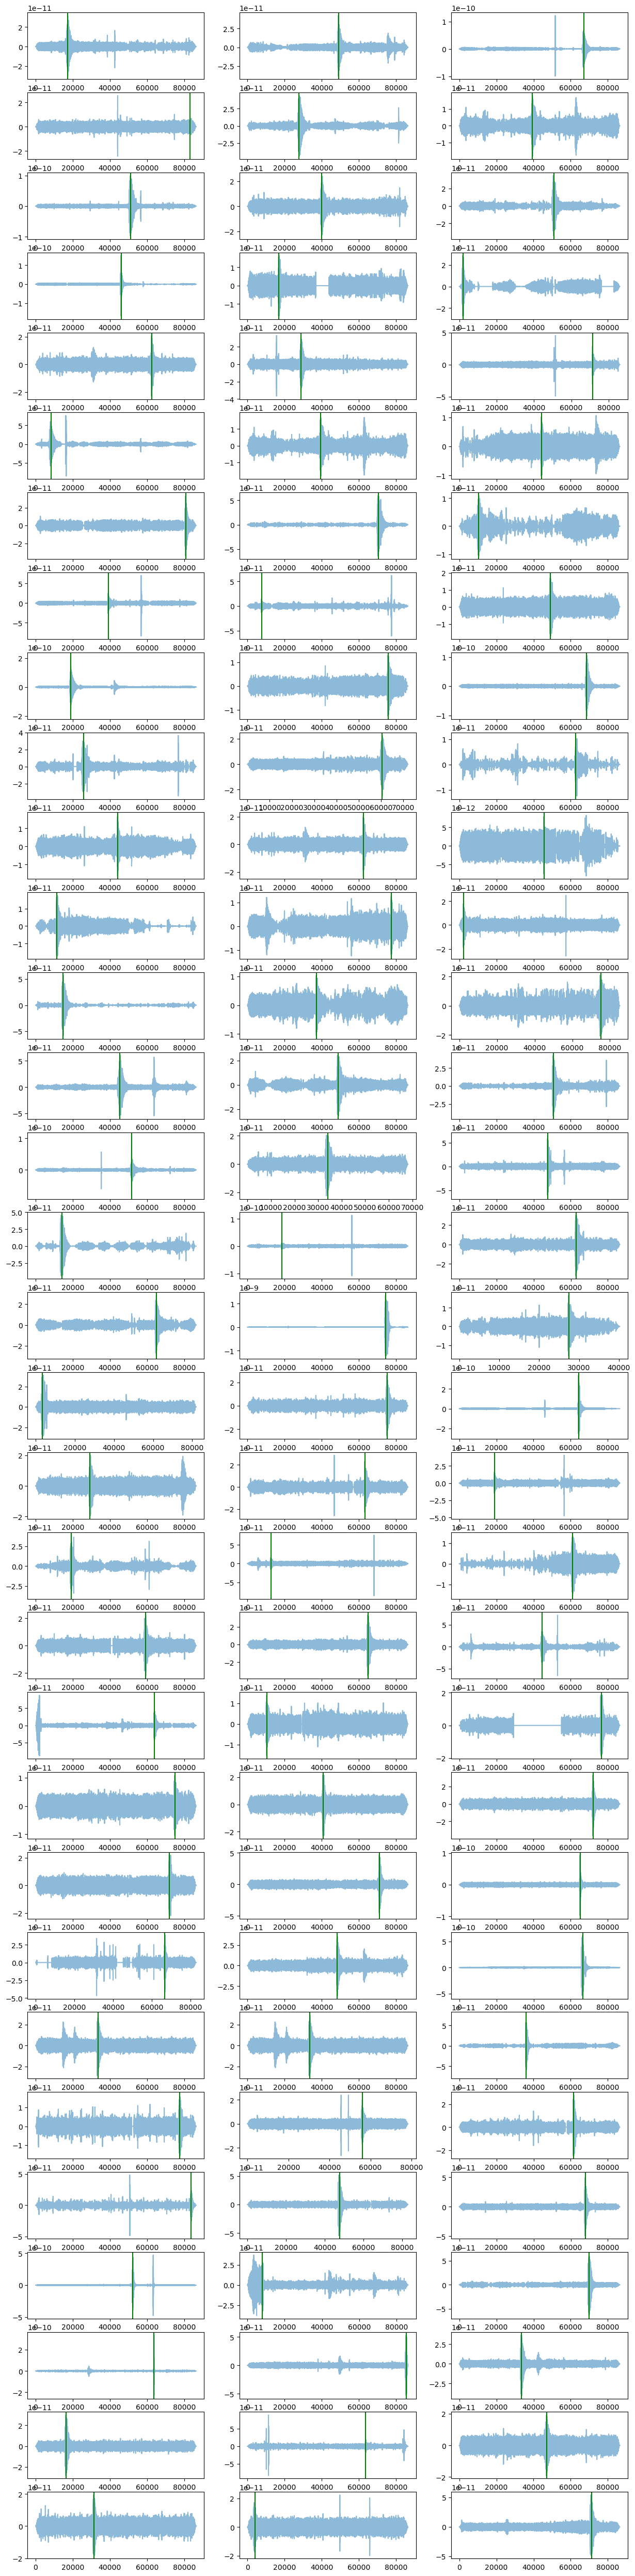

In [222]:
filtered_X_train = []
filtered_X_test = []

for stream in X_train:
    stream2 = stream.copy()
    stream2 = stream2.filter("lowpass", freq=1.0)
    stream2 = stream2.filter("highpass", freq=2.0)
    filtered_X_train.append(stream2)
for stream in X_test:
    stream2 = stream.copy()
    stream2 = stream2.filter("lowpass", freq=1.0)
    stream2 = stream2.filter("highpass", freq=2.0)
    filtered_X_test.append(stream2)

show_predictions(
    yhat_train, yhat_test, X_train=filtered_X_train, X_test=filtered_X_test
)